# Python fanout with error prone tasks.
Supposedly you have tasks to be done parallely but some of them are prone to failure. Let's define such piece of work using python.

In [3]:
import numpy as np
import time

class CustomError(Exception):
    pass

def random_error(): # return random error from three pre-defined ones.
    return np.random.choice([CustomError("I hate mondays"), 
                             CustomError("I am lazy"), 
                             CustomError("I would if I could")])

def sketchy_work(prob_of_fail, token): # return token or raise error with probability prob_of_fail
    time.sleep(1)
    if np.random.uniform() <= prob_of_fail:
        raise random_error()
    else:
        return token

sketchy_work(0.9, 'some_value') # 90% of time it will raise one of custom errors defined earlier

CustomError: I would if I could

We can build a simple wrapper to put our `sketchy_work` in a try-catch statement, like so:

In [5]:
def sketchy_work_wrapper(prob_of_fail, token):
    try:
        sketchy_work(prob_of_fail, token)
    except Exception as e:
        print(e)

sketchy_work_wrapper(0.9, 'some_work')

I am lazy


But when running a fanout using multiprocessing returning error from process is not that easy. They do not appear in any predictable order, and sometimes not every error is populated for the user to view it. So dealing with it, I found it difficult to report all the issues. Let us modify this code a bit. We will add shared variables which for now will not make that much sense but stay with me for a bit longer. It will get clear soon.

In [6]:
def sketchy_work_wrapper(prob_of_fail, token,
                         shared_success_counter,
                         shared_skips_counter,
                         shared_skip_reasons,
                         shared_lock):

    try:
        sketchy_work(prob_of_fail, token)
        with shared_lock:
            shared_success_counter.value += 1
    except Exception as e:
        with shared_lock:
            shared_skip_reasons[token] = str(e)
            shared_skips_counter.value += 1

Modified code uses shared variables which are a special variables provided by multiprocessing library. These values are shared between processes, but to prevent data raids, we will also include a `Lock()` object, which ensures our variable is not accessed when its value is already in modification by other process. A one of famous actions that we want to prevent is for instance one process taking counter value `n` and before updating it to `n+1` other process takes value `n` and after first returns `n+1` second process also returns `n+1` which is wrong because our counter should be `n+2` at this point. This is what I call "accessing an obsolete value". Putting an action of modifing variable in a `with Lock()` statement, it ensures this scenario will not happen. For dictionary variable, every process is only modyfing its own entry, hence this will not happen, but we still can use lock as it will not harm our code. Now let's see how we introduce all those variables, and how we will conduct fanout with multiprocessing.

In [7]:
def parallel_wrapper(func):

    with mp.Manager() as mgr:
        shared_lock = mgr.Lock()
        shared_success_counter = mgr.Value('successes', 0)
        shared_skips_counter = mgr.Value('skips', 0)
        shared_skip_reasons = mgr.dict()

        p = mp.Pool(mp.cpu_count())
        p.starmap(func, [(0.6, i,
                          shared_success_counter,
                          shared_skips_counter,
                          shared_skip_reasons,
                          shared_lock) for i in range(20)])
        p.close()
        p.join()

First we will open shared context manager and introduce our variables. Then we will introduce a `Pool` with number of processes that our machine can handle using `mp.cpu_count()` method. Then we will use starmap to map executions to processes. In my case I will prepare 20 different executions (with probability of failure of 60%) and map them to my 8 cpu's. Since every execution is sleeping for 1 second, I should expect for this to run about ceil(20/8) = 3 seconds. But before that we still would like to use those shared variables somehow for instance preparing some usefull information.

In [9]:
def parallel_wrapper(func):

    with mp.Manager() as mgr:
        shared_lock = mgr.Lock()
        shared_success_counter = mgr.Value('successes', 0)
        shared_skips_counter = mgr.Value('skips', 0)
        shared_skip_reasons = mgr.dict()

        p = mp.Pool(AVAILABLE_COMPUTING_POWER)
        p.starmap(func, [(0.6, i,
                          shared_success_counter,
                          shared_skips_counter,
                          shared_skip_reasons,
                          shared_lock) for i in range(20)])
        p.close()
        p.join()

        # NEW
        wrapper_successes = shared_success_counter.value
        wrapper_skips = shared_skips_counter.value
        wrapper_reasons = dict(shared_skip_reasons)

    most_common_skips = Counter(wrapper_reasons.values()).most_common()
    message = '\n'
    for s in most_common_skips:
        message += f"occurred: {s[1]} | reason: {s[0]}\n"

    print(f"SUCCEEDED: {wrapper_successes}, SKIPPED: {wrapper_skips}")
    print(message)

Modifying and printing those variables should benefit our understanding of how executions went. Now it is time to execute all this. Full example below.

In [11]:
import numpy as np
import multiprocessing as mp
import time
from collections import Counter

AVAILABLE_COMPUTING_POWER = mp.cpu_count()

class CustomError(Exception):
    pass

def random_error():
    return np.random.choice([CustomError("I hate mondays"), 
                             CustomError("I am lazy"), 
                             CustomError("I would if I could")])

def sketchy_work(prob_of_fail, token):
    time.sleep(1)
    if np.random.uniform() <= prob_of_fail:
        raise random_error()
    else:
        return token

def sketchy_work_wrapper(prob_of_fail, token,
                         shared_success_counter,
                         shared_skips_counter,
                         shared_skip_reasons,
                         shared_lock):

    try:
        sketchy_work(prob_of_fail, token)
        with shared_lock:
            shared_success_counter.value += 1
    except Exception as e:
        with shared_lock:
            shared_skip_reasons[token] = str(e)
            shared_skips_counter.value += 1


def parallel_wrapper(func):

    with mp.Manager() as mgr:
        shared_lock = mgr.Lock()
        shared_success_counter = mgr.Value('successes', 0)
        shared_skips_counter = mgr.Value('skips', 0)
        shared_skip_reasons = mgr.dict()

        p = mp.Pool(AVAILABLE_COMPUTING_POWER)
        p.starmap(func, [(0.6, i,
                          shared_success_counter,
                          shared_skips_counter,
                          shared_skip_reasons,
                          shared_lock) for i in range(20)])
        p.close()
        p.join()

        wrapper_successes = shared_success_counter.value
        wrapper_skips = shared_skips_counter.value
        wrapper_reasons = dict(shared_skip_reasons)

    most_common_skips = Counter(wrapper_reasons.values()).most_common()
    message = '\n'
    for s in most_common_skips:
        message += f"occurred: {s[1]} | reason: {s[0]}\n"

    print(f"SUCCEEDED: {wrapper_successes}, SKIPPED: {wrapper_skips}")
    print(message)

# NEW
if __name__ == '__main__':
    start = time.time()
    parallel_wrapper(sketchy_work_wrapper)
    print(f"RAN ON {AVAILABLE_COMPUTING_POWER} PROCESSES, IN {time.time()-start:.2f}[s]\n\n")

Example output:

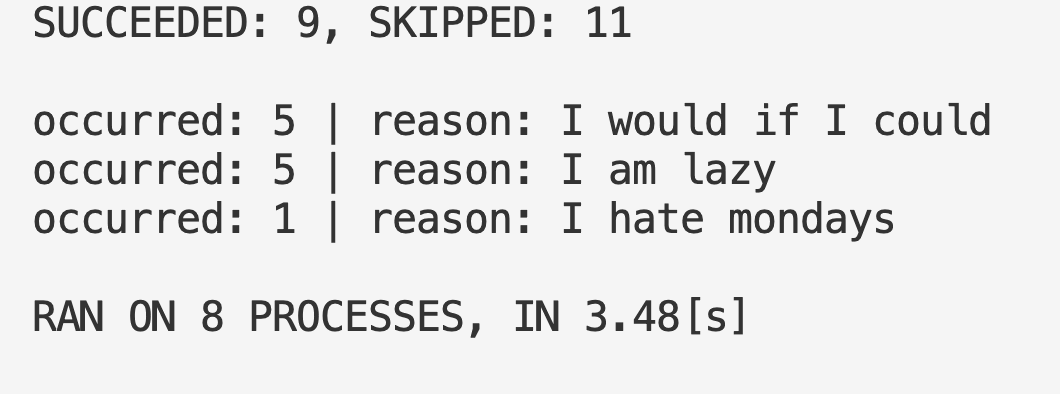